# 2.03b - Analysis of night clusters
This extends from the creation of night clusters and looks to analyse and compare them. Here we analyse some statistics behind them before delving deeper. Putting focus on cluster 2 and 3 as being quite different in the profile of the variables, lets first start to look at how the profiles are different, from the perspective of their overnight glucose. We can shorten the observed period to between 22:00 and 06:00 which - although arbitrary - is more likely to represent a sleeping period for individuals. Using this, we can then look at the BG profiles and measure at each interval if the BG is statistically different.


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pickle

from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from dtw import dtw
from datetime import time, datetime
from scipy.stats import ttest_ind, kstest
from sklearn.preprocessing import StandardScaler

from src.helper import minutes_since_night_start, cluster_colours, \
    normalise_overnight_time
from src.nights import Nights, consolidate_df_from_nights
from src.dba import dba_by_cluster
from src.reliationship_modelling import AnalyseRelationships
from src.config import FIGURES_DIR, PROCESSED_DATA_DIR

2025-08-14 17:05:19.120 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project


In [3]:
with open(PROCESSED_DATA_DIR / 'cust_analyser.pkl', 'rb') as file:
    analyser = pickle.load(file)

df_to_compare = analyser.return_dataset_with_clusters()
variables = ['cob mean', 'iob mean', 'bg mean']
scaled_cols = ['cob_mean_scaled','iob_mean_scaled', 'bg_mean_scaled']
scaler = StandardScaler()
df_to_compare[scaled_cols] = scaler.fit_transform(df_to_compare[variables])
rel = AnalyseRelationships(df_to_compare.rename(columns={'cluster_label':'cluster'}))

In [4]:
def heatmap_regression_values(df, cob_col, iob_col, variable):
    cob_matrix = df.pivot_table(index='cluster', columns='lag', values=cob_col).round(3)
    iob_matrix = df.pivot_table(index='cluster', columns='lag', values=iob_col).round(3)
    
    vmin = min(cob_matrix.min().min(), iob_matrix.min().min())
    vmax = max(cob_matrix.max().max(), iob_matrix.max().max())
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    cmap = "YlGnBu" if variable == 'p-value' else "YlGnBu_r"

    hm0 = sns.heatmap(cob_matrix, annot=True, fmt=".3f", cmap=cmap, ax=ax[0], vmin=vmin, vmax=vmax, cbar=False)
    ax[0].set_title(f'COB {variable} by Cluster and Lag')
    hm1 = sns.heatmap(iob_matrix, annot=True, fmt=".3f", cmap=cmap, ax=ax[1], vmin=vmin, vmax=vmax, cbar=False)
    ax[1].set_title(f'IOB {variable} by Cluster and Lag')

    cbar = fig.colorbar(hm1.collections[0], ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label(variable)
    
    ax[0].set_xlabel('Lag (hours)')
    ax[0].set_ylabel('Cluster')
    ax[1].set_xlabel('Lag (hours)')
    ax[1].set_ylabel('')
    ax[1].set_yticklabels([])
    plt.savefig(FIGURES_DIR / ('lag_heatmap_' + variable.replace(' ', '_') + '.png'), bbox_inches='tight')
    plt.show()

def heatmap_metrics(df, regressor):
    fig, ax = plt.subplots(figsize=(8, 3), ncols=2)
    for i, m in enumerate(['r_squared', 'mse']):
        metric_matrix = df.pivot_table(index='cluster', columns='lag', values=m).round(3)
        if m == 'r_squared':
            vmin, vmax = -1, 1
            ylabel = 'Cluster'
        elif m == 'mse':
            metric_matrix = -metric_matrix  # Invert MSE for heatmap visualisation
            vmin, vmax = -0.05, 0  # Standard range for MSE for comparison
            ylabel = None
        sns.heatmap(metric_matrix, annot=True, fmt=".3f", cmap="YlGnBu_r", vmin=vmin, vmax=vmax, ax=ax[i])
        ax[i].set_title(f'{m.upper()} by Cluster and Lag')
        ax[i].set_xlabel('Lag (hours)')
        ax[i].set_ylabel(ylabel)
    plt.savefig(FIGURES_DIR / f'lag_comparison_heatmap_{regressor}.png', bbox_inches='tight')
    plt.show()

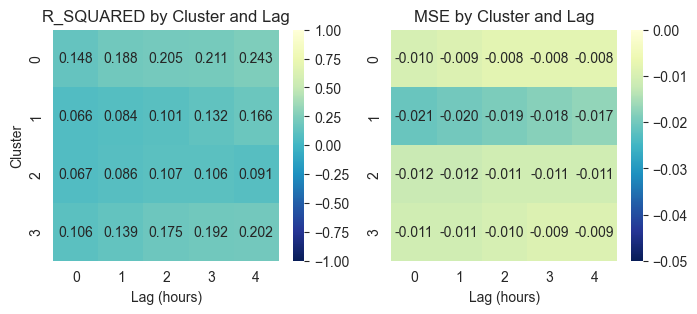

In [5]:
ols_cob_only = rel.apply_ols(['cob_lagged'])
ols_cob_only = pd.DataFrame.from_records(ols_cob_only)
heatmap_metrics(ols_cob_only, 'ols_cob')

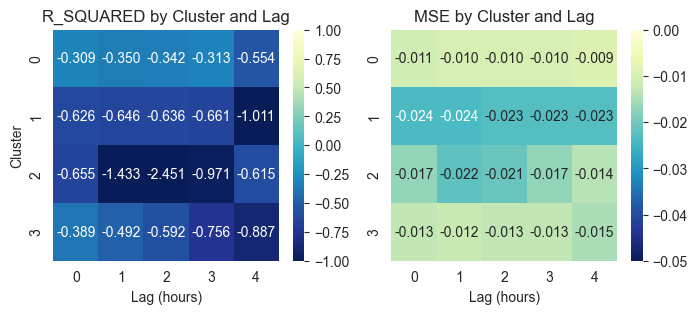

In [18]:
ols_cob_only_cv = rel.apply_cv_regression(model='LinearRegression', variables=['cob_lagged'])
ols_cob_only_cv = pd.DataFrame.from_records(ols_cob_only_cv)
heatmap_metrics(ols_cob_only_cv)

And now check each of the non-linear regression models against this baseline.

Support Vector Regression (SVR) on COB lagged values


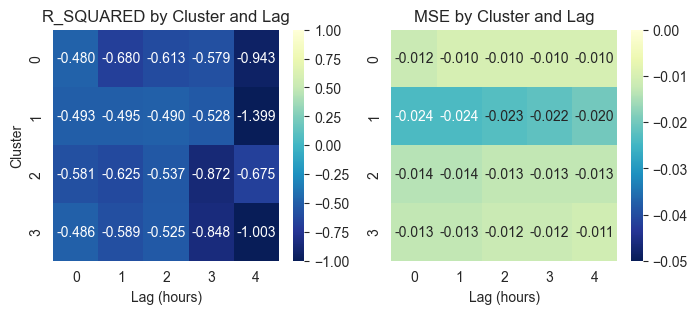

In [19]:
print('Support Vector Regression (SVR) on COB lagged values')
svm_results = rel.apply_cv_regression(model='SVR', variables=['cob_lagged'])
svm_results = pd.DataFrame.from_records(svm_results)
heatmap_metrics(svm_results)

Decision Tree on COB lagged values


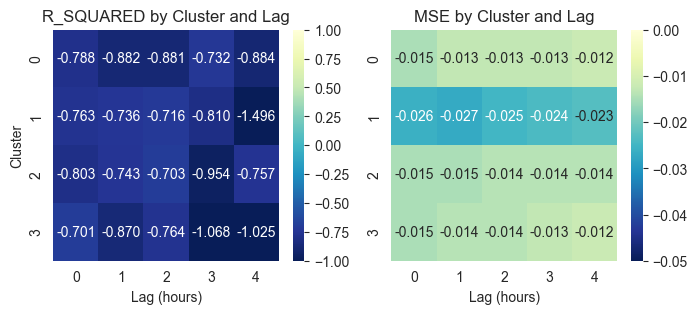

In [20]:
print('Decision Tree on COB lagged values')
dt_results = rel.apply_cv_regression(model='DecisionTreeRegressor', variables=['cob_lagged'])
dt_results = pd.DataFrame.from_records(dt_results)
heatmap_metrics(dt_results)

In [21]:
# print('Random Forest on COB lagged values')
# rf_results = rel.apply_cv_regression(model='RandomForestRegressor', variables=['cob_lagged'])
# rf_results = pd.DataFrame.from_records(rf_results)
# heatmap_metrics(rf_results)

SVR is the first non-linear regression technique we are applying, and the results notabley poorer results than the linear regression model. The R-squared values are generally lower than those from the linear regression, indicating that the model is not capturing the relationship between COB and BG as well as the linear regression model.

Given the negative R-squared scores across all non-linear models, it is clear that the models are not performing well. This suggests that the relationship between COB and BG is not well captured by these models, and that the relationship may be more complex than can be captured by these non-linear regression techniques. The negative R-squared values indicate that the models are not fitting the data well, and that they are not able to explain the variance in the data. This could be due to a number of factors, including the complexity of the relationship between COB and BG, the presence of noise in the data, or the limitations of the models themselves. Given this, we can conclude that the relationship between COB and BG is not well captured by these non-linear regression techniques, and that further investigation is needed to understand the relationship better. We can also look at how IOB performs in comparison to COB.

In [22]:
# print('Linear Regression on IOB lagged values')
# linear_results = rel.apply_cv_regression(model='LinearRegression',
#                                           variables=['iob_lagged'])
# linear_results = pd.DataFrame.from_records(linear_results)
# heatmap_metrics(linear_results)
#
# print('Support Vector Regression (SVR) on IOB lagged values')
# svm_results = rel.apply_cv_regression(model='SVR', variables=['iob_lagged'])
# svm_results = pd.DataFrame.from_records(svm_results)
# heatmap_metrics(svm_results)
#
# print('Decision Tree on IOB lagged values')
# dt_results = rel.apply_cv_regression(model='DecisionTreeRegressor',
#                                      variables=['iob_lagged'])
# dt_results = pd.DataFrame.from_records(dt_results)
# heatmap_metrics(dt_results)
# print('Random Forest on IOB lagged values')
# rf_results = rel.apply_cv_regression(model='RandomForestRegressor',
#                                      variables=['iob_lagged'])
# rf_results = pd.DataFrame.from_records(rf_results)
# heatmap_metrics(rf_results)

Unsurprisingly, the results for IOB are better than those for COB, aligning to the previous analysis with OLS, with the R-squared values being significantly higher and the MSE values being lower. This suggests that the relationship between IOB and BG is much stronger than that of COB and BG, which aligns with our earlier findings. The non-linear models also perform better on IOB than on COB, with the SVR model performing particularly well. This suggests that the relationship between IOB and BG is more complex than can be captured by a simple linear regression model, but that it can be captured by a non-linear regression model. Overall, these results suggest that the relationship between IOB and BG is much stronger than that of COB and BG, and that non-linear regression models can capture this relationship more effectively than linear regression models. Finally, lets analyse the correlations between the variables in the overnight period for each cluster, to see how they relate to each other. This will allow us to see how the relationships between COB, IOB and BG differ between clusters, and how they change over time. We'll look at Pearson correlation coefficients to study the linear relationships for each cluster and lag, and then Spearman correlation coefficients to study the non-linear relationships for each cluster and lag. This will allow us to see how the relationships between COB, IOB and BG differ between clusters, and how they change over time.

I want to test whether the data is normally distributed, which is a requirement for Pearson correlation. If the data is not normally distributed, we can use Spearman correlation, which does not require normality. We can use the Kolmogorov-Smirnov test to check for normality. The null hypothesis of the Kolmogorov-Smirnov (KS) test (https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm is based on the maximum distance between the empirical distribution function and a normal cumulative distribution function and is appropriate for large sample sizes, in comparison to - for example - the Shapiro-Wilk test. The null hypothesis is that the data is normally distributed, and the alternative hypothesis is that the data is not normally distributed. If the p-value is less than 0.05, we reject the null hypothesis and conclude that the data is not normally distributed. The following will check if the variables are normally distributed for each cluster using the KS test.



In [23]:
night_start = time(17, 00)
def check_normality_cluster(df, col):
    results = []
    for cluster, group in df.groupby('cluster'):
        mean = group[col].mean()
        sigma = group[col].std()
        p, stat = kstest(group[col], 'norm', args=(mean, sigma))
        results.append({'cluster': cluster, 'statistic': stat, 'p-value': p})
    return pd.DataFrame(results)

def check_normality_by_time(df, col, night_start):
    results = []
    for cluster, group in df.reset_index().groupby('cluster'):
        group['time'] = group['datetime'].dt.time
        for time, time_group in group.groupby('time'):
            mean = time_group[col].mean()
            sigma = time_group[col].std()
            p, stat = kstest(time_group[col], 'norm', args=(mean, sigma))
            results.append({'cluster': cluster, 'time': time, 'statistic': stat, 'p-value': p})
    return pd.DataFrame(results)

df_ks_by_cluster = pd.DataFrame(columns=['cluster', 'statistic', 'p-value'])
df_ks_by_cluster = df_ks_by_cluster.astype({'cluster': 'int', 'statistic': 'float', 'p-value': 'float'})
variables = ['bg mean', 'cob mean', 'iob mean']
for v in variables:
    df_ks = check_normality_cluster(df_to_compare.rename(columns={'cluster_label': 'cluster'}), v)
    df_ks['variable'] = v
    df_ks_by_cluster = pd.concat([df_ks_by_cluster, df_ks])

night_start = time(17, 0)
df_ks_by_time = pd.DataFrame(columns=['cluster', 'time', 'statistic', 'p-value'])
df_ks_by_time = df_ks_by_time.astype({'cluster': 'int', 'time': 'str', 'statistic': 'float', 'p-value': 'float'})
for v in variables:
    df_ks = check_normality_by_time(df_to_compare.rename(columns={'cluster_label': 'cluster'}), v, night_start)
    df_ks['variable'] = v
    df_ks['minutes_since_night_start'] = df_ks['time'].apply(lambda t: minutes_since_night_start(t, night_start))
    df_ks['rank'] = df_ks['minutes_since_night_start'].rank(method='dense').astype(int)
    df_ks_by_time = pd.concat([df_ks_by_time, df_ks.sort_values(['cluster', 'variable', 'minutes_since_night_start'], ascending=True)])

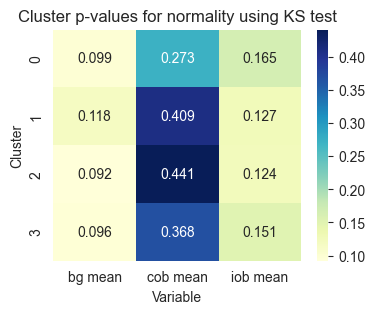

In [24]:
ks_cluster_pval_matrix = df_ks_by_cluster.pivot_table(index='cluster', columns='variable', values='p-value')

plt.figure(figsize=(4, 3))
sns.heatmap(ks_cluster_pval_matrix, annot=True, fmt=".3f", cmap="YlGnBu")
plt.xlabel('Variable')
plt.ylabel('Cluster')
plt.title('Cluster p-values for normality using KS test')
plt.savefig(FIGURES_DIR / 'ks_cluster_pval_matrix.png', bbox_inches='tight')
plt.show()

Test by variable for normality across dataset...
bg mean variable:
Skewness: 1.3232107131375277, Kurtosis: 2.47428686933728
Proportion of zero values: 0.0
KS p-value: 0.09912941466112418


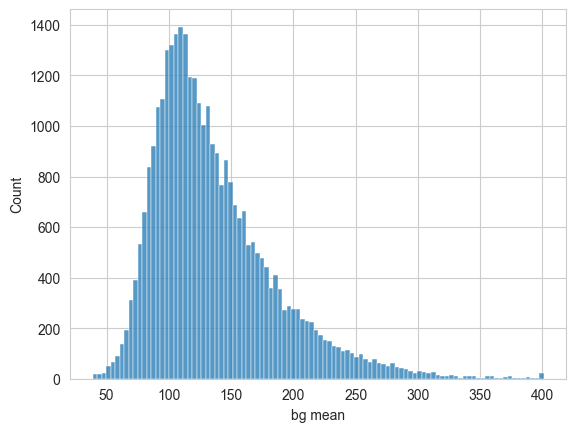

cob mean variable:
Skewness: 3.0417610935584736, Kurtosis: 10.150449498060986
Proportion of zero values: 0.7037319814317127
KS p-value: 0.14409384313616258


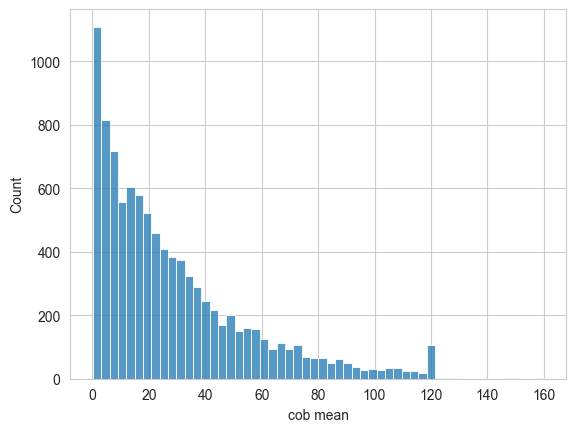

iob mean variable:
Skewness: 3.413705083305615, Kurtosis: 20.73161109003534
Proportion of zero values: 0.0030234546787197654
KS p-value: 0.18768201573270715


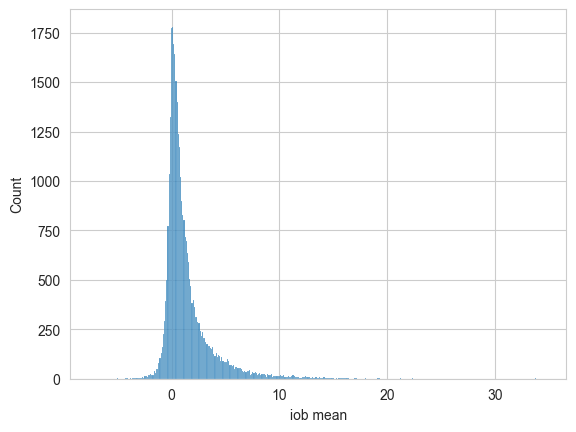

In [25]:
print('Test by variable for normality across dataset...')
for v in ['bg mean', 'cob mean', 'iob mean']:
    print(f'{v} variable:')
    var_to_test = df_to_compare.reset_index()[v]
    zero_proportion = var_to_test[var_to_test == 0].count() / len(var_to_test)
    print(f'Skewness: {var_to_test.skew()}, Kurtosis: {var_to_test.kurtosis()}')
    print('Proportion of zero values:', zero_proportion)
    var_to_test = var_to_test[var_to_test != 0] if zero_proportion > 0.6 else var_to_test
    p, stat = kstest(var_to_test, 'norm', args=(var_to_test.mean(), var_to_test.std()))
    print(f'KS p-value: {p}')
    sns.histplot(var_to_test)
    plt.show()

Cluster p-values for normality using KS test:


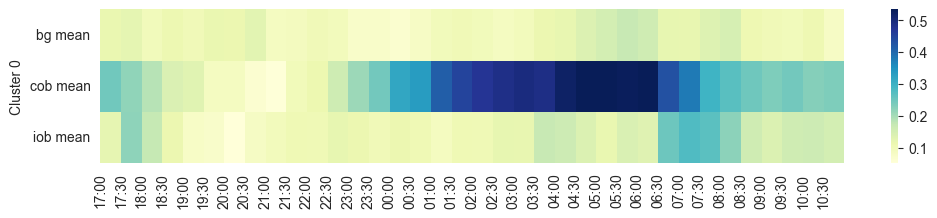

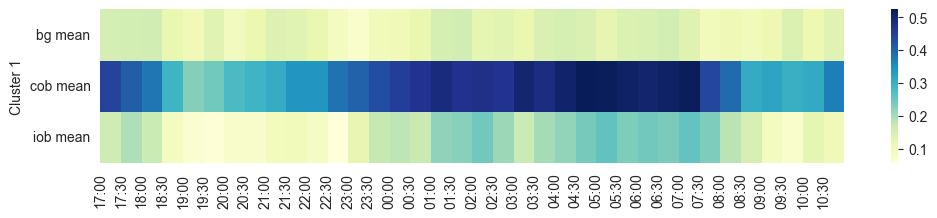

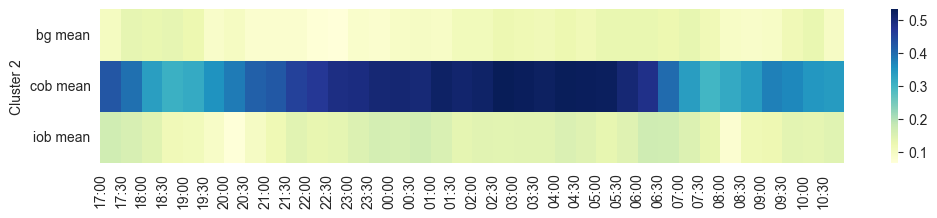

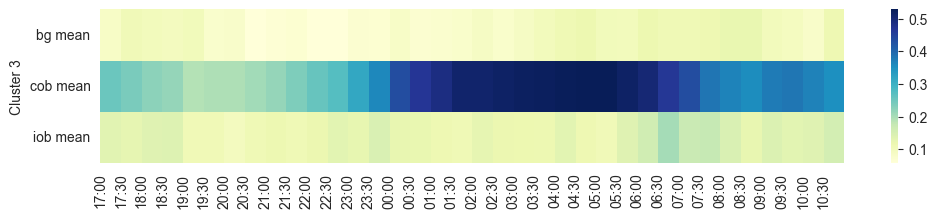

In [26]:
def format_time_to_hhmm(time_obj):
    """Formats a datetime.time object to HH:MM string."""
    return time_obj.strftime('%H:%M')

print('Cluster p-values for normality using KS test:')
x_ticks = df_ks_by_time[['rank','time']].drop_duplicates().sort_values('rank')
x_ticks['time'] = x_ticks['time'].apply(format_time_to_hhmm)
for c, group in df_ks_by_time.groupby('cluster'):
    ks_by_time_pval_matrix = group.pivot_table(index='variable', columns='rank', values='p-value')
    fig = plt.figure(figsize=(12, 2))
    sns.heatmap(ks_by_time_pval_matrix, annot=False, fmt=".3f", cmap="YlGnBu")
    plt.ylabel(f'Cluster {c}')
    plt.xlabel(None)
    plt.xticks(x_ticks['rank']-1, x_ticks['time'], rotation=90)
    plt.show()


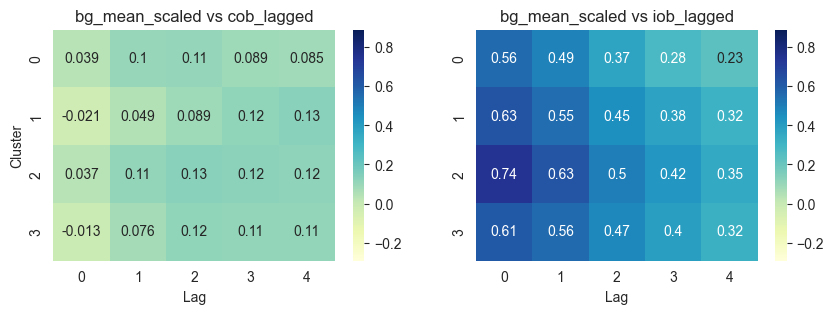

In [27]:
df_spearman = rel.calculate_correlation(corr_type='spearman')
spearman_agg = df_spearman.groupby(['variables', 'lag', 'cluster']).agg({'correlation': 'mean'}).pivot_table(
    index=['variables', 'cluster'], columns=['lag'], values='correlation').round(3).sort_index(axis=1, level=0)
vmin = df_spearman['correlation'].min()
vmax = df_spearman['correlation'].max()
fig, ax = plt.subplots(figsize=(10, 3), ncols=2)
for i, (v, df) in enumerate(spearman_agg.groupby('variables')):
    if v == 'cob_lagged vs iob_lagged':
        continue
    sns.heatmap(df.reset_index(drop=True), annot=True, cmap='YlGnBu', vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(v)
    ax[i].set_ylabel('Cluster' if i==0 else None)
    ax[i].set_xlabel('Lag')
plt.savefig(FIGURES_DIR / 'spearman_correlation_matrices.png', bbox_inches='tight')
plt.show()


The following looks at how the Spearman correlation changes for each variable against BG over time, for each cluster, but without a lag for COB and IOB.

Spearman correlation for variable bg_mean_scaled vs cob_lagged at lag 0:
Cluster 0 SD: 0.16
Cluster 1 SD: 0.13
Cluster 2 SD: 0.10
Cluster 3 SD: 0.10


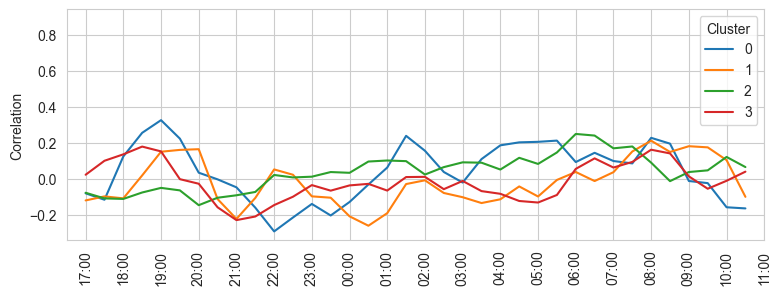

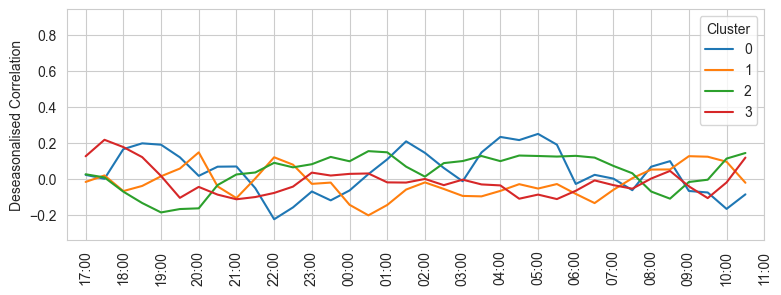

Spearman correlation for variable bg_mean_scaled vs iob_lagged at lag 0:
Cluster 0 SD: 0.20
Cluster 1 SD: 0.10
Cluster 2 SD: 0.08
Cluster 3 SD: 0.16


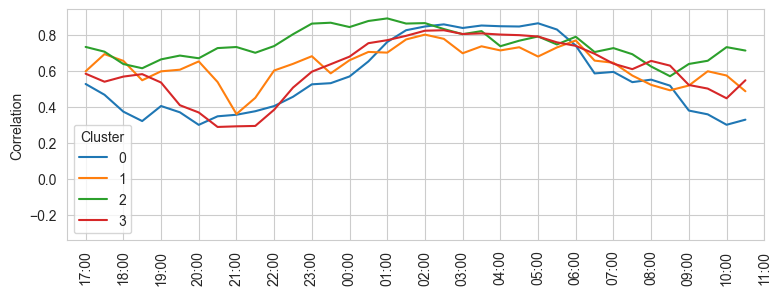

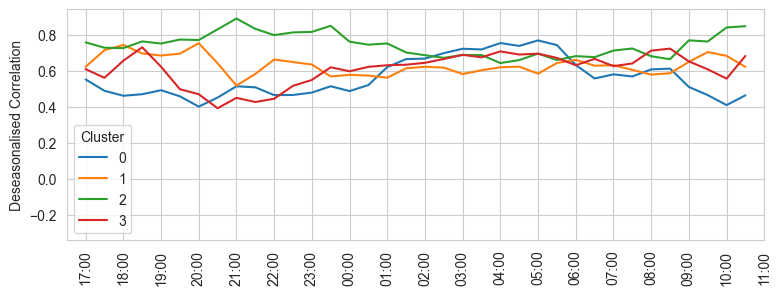

Spearman correlation for variable cob_lagged vs iob_lagged at lag 0:
Cluster 0 SD: 0.19
Cluster 1 SD: 0.17
Cluster 2 SD: 0.14
Cluster 3 SD: 0.26


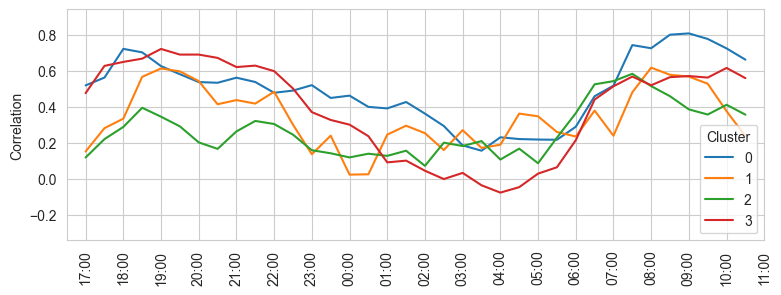

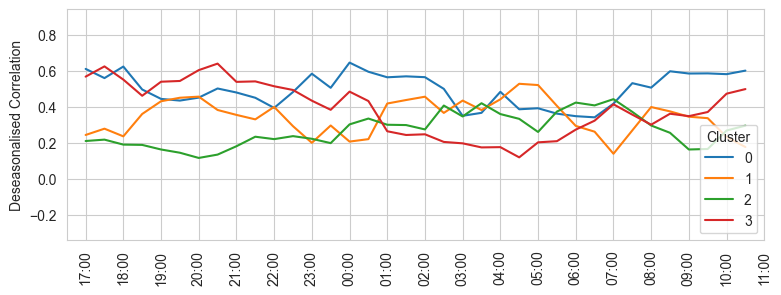

In [44]:
line_colours = cluster_colours()
lag = 0
for v, group_df in df_spearman[df_spearman['lag']==lag].groupby('variables'):
    print(f'Spearman correlation for variable {v} at lag {lag}:')
    group_df = group_df.drop(columns='variables')
    decomposition = seasonal_decompose(group_df['correlation'], model='additive', period=period)
    group_df['seasonal'] = decomposition.seasonal
    group_df['deseasonalised_correlation'] = group_df['correlation'] - group_df['seasonal']
    for c, cluster_df in group_df.groupby('cluster'):
        print(f'Cluster {c} SD: {cluster_df["correlation"].std():.2f}')
        period = len(cluster_df)
    for y_col in ['correlation','deseasonalised_correlation']:
        fig, ax = plt.subplots(figsize=(9, 3))
        group_df['time'] = group_df['time'].apply(lambda x: normalise_overnight_time(x, 11))
        sns.lineplot(group_df, x='time', y=y_col, hue='cluster', palette=line_colours, ax=ax)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
        plt.xlabel(None)
        plt.ylim(df_spearman['correlation'].min()-0.05,df_spearman['correlation'].max()+0.05)
        plt.xlim(group_df['time'].min()-timedelta(minutes=30), group_df['time'].max()+timedelta(minutes=30))
        plt.xticks(rotation=90)
        plt.legend(title='Cluster')
        plt.ylabel(f'{y_col.replace("_", " ").title()}')
        plt.savefig(FIGURES_DIR / f'spearman_timeseries_{v.replace(" ", "_")}_{y_col}.png', bbox_inches='tight')
        plt.show()

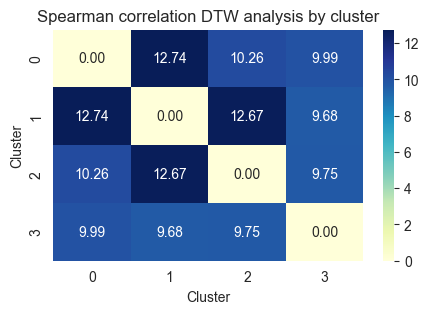

In [29]:
title = 'Spearman correlation DTW analysis by cluster'
heatmap_dtw_distance(df_spearman[df_spearman['variables']=='bg_mean_scaled vs cob_lagged'], 'correlation', title)

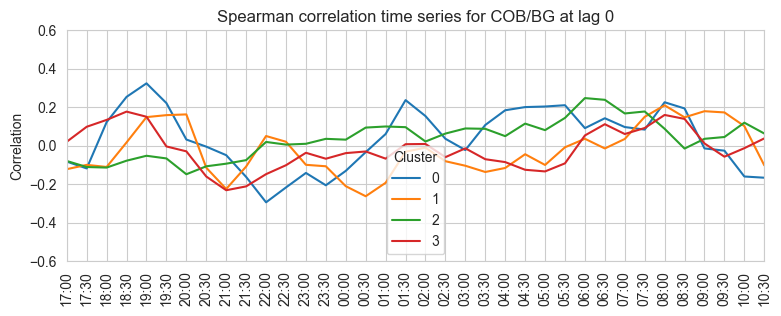

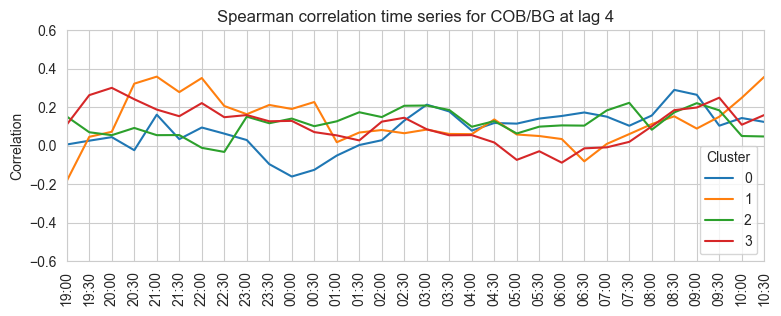

In [30]:
v = 'bg_mean_scaled vs cob_lagged'
sp_new = df_spearman[(df_spearman['variables']==v)].copy()
sp_new = sp_new.drop(columns='variables')
sp_new['minutes_since_night_start'] = sp_new['time'].apply(lambda t: minutes_since_night_start(t, night_start))

vmin = sp_new['correlation'].min()
vmax = sp_new['correlation'].max()

for lag in [0,4]:
    sp_temp = sp_new[sp_new['lag']==lag].copy()

    fig, ax = plt.subplots(figsize=(9, 3))
    sp_temp['time'] = sp_temp['time'].apply(lambda x: normalise_overnight_time(x, 11))
    sns.lineplot(sp_temp, x='time', y='correlation', hue='cluster', palette=line_colours, ax=ax)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    plt.xlabel(None)
    plt.ylim(-0.6,0.6)
    plt.xlim(sp_temp['time'].min(), sp_temp['time'].max())
    plt.xticks(rotation=90)
    plt.legend(title='Cluster')
    plt.ylabel('Correlation')
    plt.title(f'Spearman correlation time series for COB/BG at lag {lag}')
    plt.savefig(FIGURES_DIR / f'spearman_timeseries_cob_bg_at_lag{lag}.png', bbox_inches='tight')
    plt.show()

Now looking at Pearson correlation for comparison

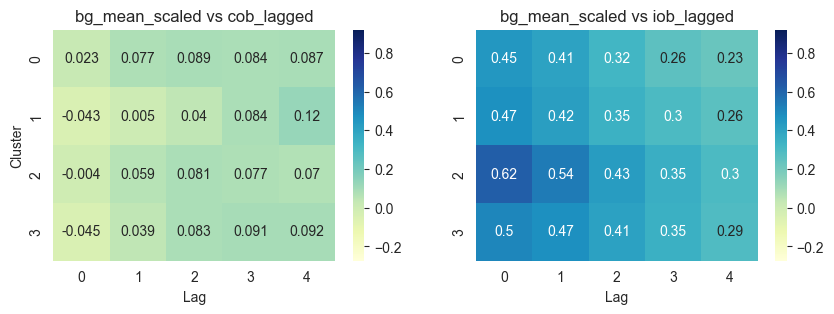

In [31]:
df_pearson = rel.calculate_correlation(corr_type='pearson')
pearson_agg = df_pearson.groupby(['variables', 'lag', 'cluster']).agg({'correlation': 'mean'}).pivot_table(
    index=['variables', 'cluster'], columns=['lag'], values='correlation').round(3).sort_index(axis=1, level=0)
vmin = df_pearson['correlation'].min()
vmax = df_pearson['correlation'].max()
fig, ax = plt.subplots(figsize=(10, 3), ncols=2)
for i, (v, df) in enumerate(pearson_agg.groupby('variables')):
    if v == 'cob_lagged vs iob_lagged':
        continue
    sns.heatmap(df.reset_index(drop=True), annot=True, cmap='YlGnBu', vmin=vmin, vmax=vmax, ax=ax[i])
    ax[i].set_title(v)
    ax[i].set_ylabel('Cluster' if i==0 else None)
    ax[i].set_xlabel('Lag')
plt.savefig(FIGURES_DIR / 'pearson_correlation_matrices.png', bbox_inches='tight')
plt.show()

Pearson correlation for variable bg_mean_scaled vs cob_lagged at lag 0:


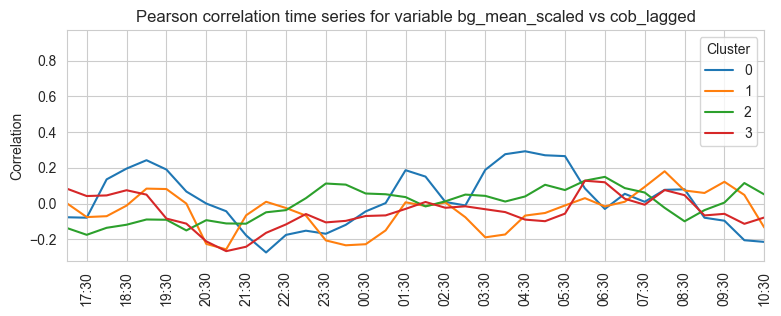

Pearson correlation for variable bg_mean_scaled vs iob_lagged at lag 0:


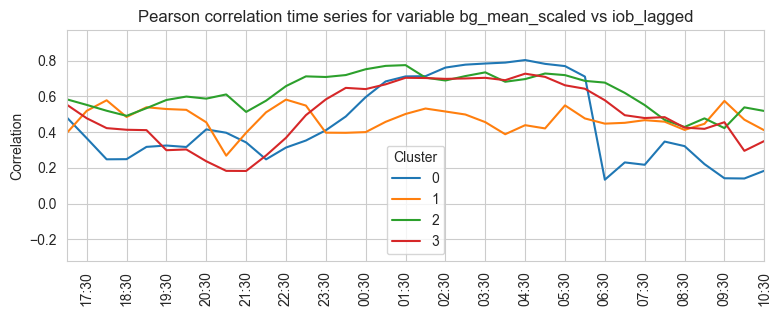

Pearson correlation for variable cob_lagged vs iob_lagged at lag 0:


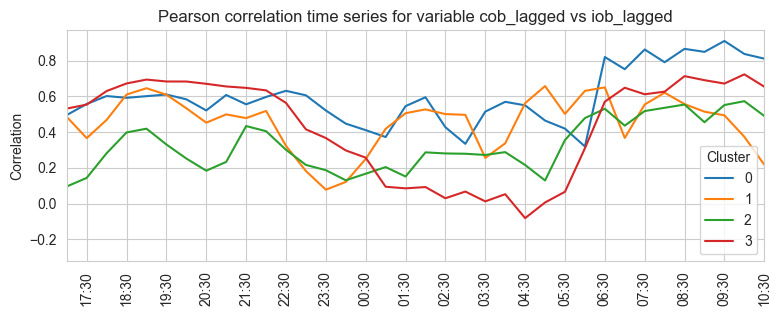

In [32]:
line_colours = cluster_colours()
lag = 0
for v, group_df in df_pearson[df_pearson['lag']==lag].groupby('variables'):
    print(f'Pearson correlation for variable {v} at lag {lag}:')
    group_df = group_df.drop(columns='variables')

    fig, ax = plt.subplots(figsize=(9, 3))
    group_df['time'] = group_df['time'].apply(lambda x: normalise_overnight_time(x, 11))
    sns.lineplot(group_df, x='time', y='correlation', hue='cluster', palette=line_colours, ax=ax)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
    plt.xlabel(None)
    plt.ylim(df_pearson['correlation'].min()-0.05,df_pearson['correlation'].max()+0.05)
    plt.xlim(group_df['time'].min(), group_df['time'].max())
    plt.xticks(rotation=90)
    plt.legend(title='Cluster')
    plt.ylabel('Correlation')
    plt.title(f'Pearson correlation time series for variable {v}')
    plt.savefig(FIGURES_DIR / f'pearson_timeseries_{v.replace(" ", "_")}.png', bbox_inches='tight')
    plt.show()